# Finding Heavy Traffic Indicators on I-94

We're going to analyze a dataset about the westbound traffic on the [I-94 Interstate highway](https://en.wikipedia.org/wiki/Interstate_94).

John Hogue made the dataset available, and you can download it from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume).

The goal of our analysis is to determine a few indicators of heavy traffic on I-94. These indicators can be weather type, time of the day, time of the week, etc. For instance, we may find out that the traffic is usually heavier in the summer or when it snows.

In [1]:
import pandas as pd
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

df.head(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [2]:
df.tail(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,None,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


## Analyzing Traffic Volume

The [dataset documentation](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume) mentions that a station located approximately midway between Minneapolis and Saint Paul recorded the traffic data. Also, the station only records westbound traffic (cars moving from east to west).

![I-94 Map](https://s3.amazonaws.com/dq-content/524/i94_figma.png)

This means that the results of our analysis will be about the westbound traffic in the proximity of that station. In other words, we should avoid generalizing our results for the entire I-94 highway.

In the next exercise, we're going to plot a histogram to visualize the distribution of the `traffic_volume` column.

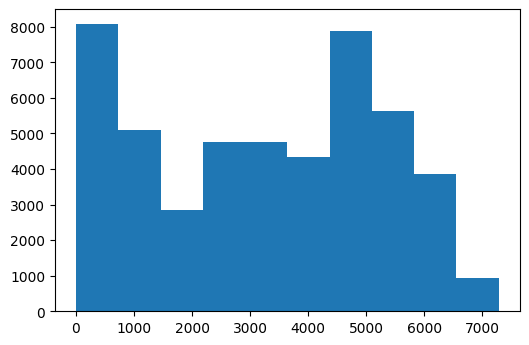

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(df['traffic_volume'])
plt.show()

In [5]:
df['traffic_volume'].describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

Based on the histogram and the statistics above, we can likely conclude that...

* About 25% of the time, there were 1,193 cars or fewer passing the station each hour — this probably occurs during the night, or when a road is under construction.
* About 25% of the time, the traffic volume was four times as much (4,933 cars or more).

This possibility that nighttime and daytime might influence traffic volume gives our analysis an interesting direction: comparing daytime with nighttime data.

We'll start by dividing the dataset into two parts:

* Daytime data: hours from 7 a.m. to 7 p.m. (12 hours)
* Nighttime data: hours from 7 p.m. to 7 a.m. (12 hours)

While this is not a perfect criterion for distinguishing between nighttime and daytime, it's a good starting point.

## Traffic Volume: Day vs. Night

In [6]:
df['date_time'] = pd.to_datetime(df['date_time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   holiday              48204 non-null  object        
 1   temp                 48204 non-null  float64       
 2   rain_1h              48204 non-null  float64       
 3   snow_1h              48204 non-null  float64       
 4   clouds_all           48204 non-null  int64         
 5   weather_main         48204 non-null  object        
 6   weather_description  48204 non-null  object        
 7   date_time            48204 non-null  datetime64[ns]
 8   traffic_volume       48204 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 3.3+ MB


In [7]:
df['hour'] = df['date_time'].dt.hour
print(df['hour'])

0         9
1        10
2        11
3        12
4        13
         ..
48199    19
48200    20
48201    21
48202    22
48203    23
Name: hour, Length: 48204, dtype: int64


In [8]:
day = df.copy()[(df['date_time'].dt.hour >= 7) & (df['date_time'].dt.hour < 19)]
print(day.shape)

(23877, 10)


In [9]:
night = df.copy()[(df['date_time'].dt.hour < 7) | (df['date_time'].dt.hour >= 19)]
print(night.shape)

(24327, 10)


We have divided the dataset into two parts:

* Daytime data: hours from 7 AM to 7 PM (12 hours)
* Nighttime data: hours from 7 PM to 7 AM (12 hours)

Now we're going to compare the traffic volume at night and during day using a side-by-side grid chart.

## Traffic Volume: Day vs. Night (II)

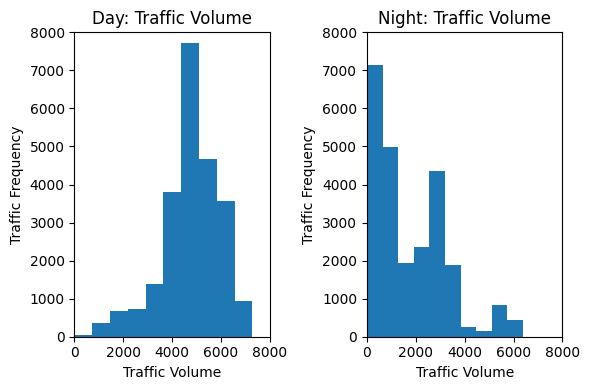

In [10]:
plt.subplot(1, 2, 1)
plt.hist(day['traffic_volume'])
plt.title('Day: Traffic Volume')
plt.xlabel('Traffic Volume')
plt.ylabel('Traffic Frequency')
plt.xlim([0, 8000])
plt.ylim([0, 8000])

plt.subplot(1, 2, 2)
plt.hist(night['traffic_volume'])
plt.title('Night: Traffic Volume')
plt.xlabel('Traffic Volume')
plt.ylabel('Traffic Frequency')
plt.xlim([0, 8000])
plt.ylim([0, 8000])

plt.tight_layout()
plt.show()

In [11]:
day['traffic_volume'].describe()

count    23877.000000
mean      4762.047452
std       1174.546482
min          0.000000
25%       4252.000000
50%       4820.000000
75%       5559.000000
max       7280.000000
Name: traffic_volume, dtype: float64

In [12]:
night['traffic_volume'].describe()

count    24327.000000
mean      1785.377441
std       1441.951197
min          0.000000
25%        530.000000
50%       1287.000000
75%       2819.000000
max       6386.000000
Name: traffic_volume, dtype: float64

The day histogram has more of a normal distribution (maybe a slight left skew), whereas the night histogram has more right skew. This indicates that traffic is heavier during the day than at night, and traffic at night is generally light.

Our goal is to find indicators of heavy traffic, so we will decide to only focus on the daytime data moving forward.

## Time Indicators

One of the possible indicators of heavy traffic is time. There might be more people on the road in a certain month, on a certain day, or at a certain time of the day.

We're going to look at a few line plots showing how the traffic volume changed according to the following parameters:

* Month
* Day of the week
* Time of day

The fastest way to get the average traffic volume for each month is by using the `DataFrame.groupby()` [method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html).

We'll start by getting the monthly traffic averages, then generate a line plot to visualize how the traffic volume changed each month on average.

In [13]:
day['month'] = day['date_time'].dt.month
by_month = day.groupby('month').mean()
by_month['traffic_volume']

month
1     4495.613727
2     4711.198394
3     4889.409560
4     4906.894305
5     4911.121609
6     4898.019566
7     4595.035744
8     4928.302035
9     4870.783145
10    4921.234922
11    4704.094319
12    4374.834566
Name: traffic_volume, dtype: float64

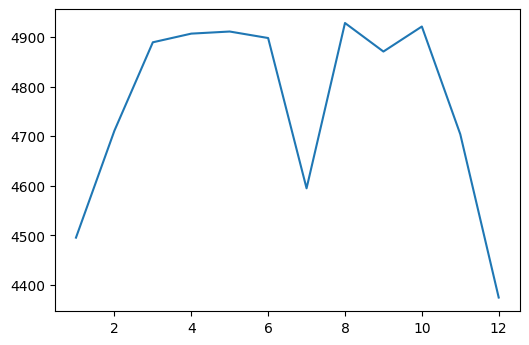

In [14]:
plt.plot(by_month['traffic_volume'])
plt.show()

We can notice that the traffic generally lighter in the winter months, and heavier in the summer months, with one interesting exception: July.

This could be explored further - was there a shutdown in a specific year that caused the drop in July? Is this part of a larger trend for the month as a whole?

## Time Indicators (II)

We'll now continue with building line plots for another time unit: day of the week.

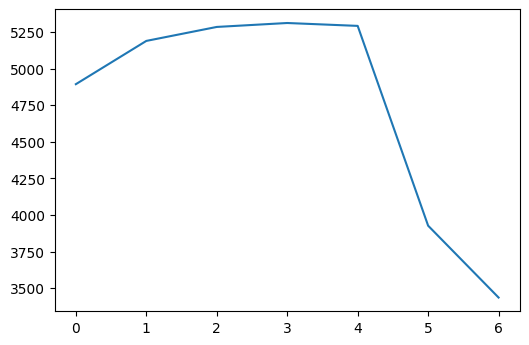

In [15]:
day['dayofweek'] = day['date_time'].dt.dayofweek
by_dayofweek = day.groupby('dayofweek').mean()
by_dayofweek['traffic_volume']  # 0 is Monday, 6 is Sunday
plt.plot(by_dayofweek['traffic_volume'])
plt.show()

We see a clear difference between business days (Monday-Friday/0-4) containing much larger volumes of traffic than weekends (Saturday-Sunday/5-6).

## Time Indicators (III)

Previously, we found that the traffic volume is significantly heavier on business days compared to the weekends.

We'll now generate a line plot for the time of day. The weekends, however, will drag down the average values, so we're going to look at the averages separately. To do that, we'll start by splitting the data based on the day type: business day or weekend.

In [16]:
day['hour'] = day['date_time'].dt.hour
bussiness_days = day.copy()[day['dayofweek'] <= 4] # 4 == Friday
weekend = day.copy()[day['dayofweek'] >= 5] # 5 == Saturday
by_hour_business = bussiness_days.groupby('hour').mean()
by_hour_weekend = weekend.groupby('hour').mean()

print(by_hour_business['traffic_volume'])
print(by_hour_weekend['traffic_volume'])

hour
7     6030.413559
8     5503.497970
9     4895.269257
10    4378.419118
11    4633.419470
12    4855.382143
13    4859.180473
14    5152.995778
15    5592.897768
16    6189.473647
17    5784.827133
18    4434.209431
Name: traffic_volume, dtype: float64
hour
7     1589.365894
8     2338.578073
9     3111.623917
10    3686.632302
11    4044.154955
12    4372.482883
13    4362.296564
14    4358.543796
15    4342.456881
16    4339.693805
17    4151.919929
18    3811.792279
Name: traffic_volume, dtype: float64


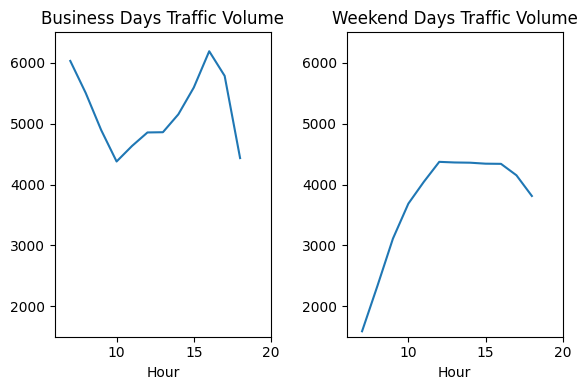

In [17]:
plt.subplot(1, 2, 1)
plt.plot(by_hour_business['traffic_volume'])
plt.title('Business Days Traffic Volume')
plt.xlim(6, 20)
plt.ylim(1500, 6500)
plt.xlabel('Hour')

plt.subplot(1, 2, 2)
plt.plot(by_hour_weekend['traffic_volume'])
plt.title('Weekend Days Traffic Volume')
plt.xlim(6, 20)
plt.ylim(1500, 6500)
plt.xlabel('Hour')

plt.tight_layout()
plt.show()

The graphs support our earlier conclusion that traffic is busier in business days than weekends. On business days, the rush hours are at the beginning of the day (approx. 7 A.M.) and peaks again in the afternoon (approx. 4 P.M.).

We have found a few time indicators of heavy traffic:
* Summer months, in general, have heavier traffic than winter months.
* Business days are significantly heavier for traffic than weekends.
* On business days, the heaviest times are at 7 A.M. and 4 P.M.

## Weather Indicators

So far, we've focused on finding time indicators for heavy traffic, and we reached the following conclusions:

* The traffic is usually heavier during warm months (March–October) compared to cold months (November–February).
* The traffic is usually heavier on business days compared to weekends.
* On business days, the rush hours are around 7 and 16.

Another possible indicator of heavy traffic is weather. The dataset provides us with a few useful columns about weather: `temp`, `rain_1h`, `snow_1h`, `clouds_all`, `weather_main`, `weather_description`.

A few of these columns are numerical so we'll start by looking up their correlation values with `traffic_volume`.

In [18]:
day.corr()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,hour,month,dayofweek
temp,1.000000,0.010815,-0.019286,-0.135519,0.128317,0.162691,0.222072,0.000188
rain_1h,0.010815,1.000000,-0.000091,0.004993,0.003697,0.008279,0.001176,-0.009683
snow_1h,-0.019286,-0.000091,1.000000,0.027721,0.001265,0.003923,0.026768,-0.008814
clouds_all,-0.135519,0.004993,0.027721,1.000000,-0.032932,0.023685,0.000595,-0.041980
traffic_volume,0.128317,0.003697,0.001265,-0.032932,1.000000,0.172704,-0.022337,-0.416453
hour,0.162691,0.008279,0.003923,0.023685,0.172704,1.000000,0.008145,-0.002767
month,0.222072,0.001176,0.026768,0.000595,-0.022337,0.008145,1.000000,0.013656
dayofweek,0.000188,-0.009683,-0.008814,-0.041980,-0.416453,-0.002767,0.013656,1.000000


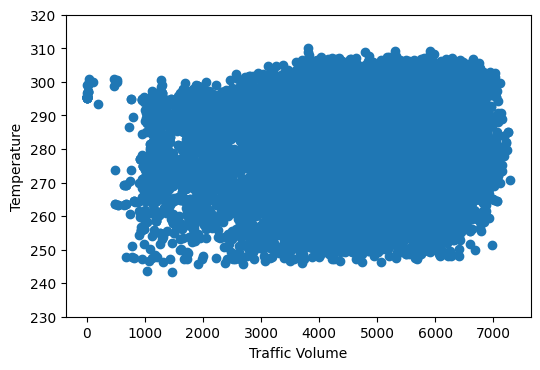

In [19]:
plt.scatter(day['traffic_volume'], day['temp'])
plt.ylim(230, 320) #remove outliers
plt.xlabel('Traffic Volume')
plt.ylabel('Temperature')
plt.show()

It does not appear that any of these weather columns seem like reliable indicators for heavy traffic.

## Weather Types

To see if we can find more useful data, we'll look next at the categorical weather-related columns: `weather_main` and `weather_description`.

We're going to calculate the average traffic volume associated with each unique value in these two columns, grouping the data by `weather_main` and `weather_description` while using the mean as an aggregate function.

We'll create a bar plot for the `traffic_volume` column of `by_weather_main` and `by_weather_description`.

In [20]:
by_weather_main = day.groupby('weather_main').mean()
by_weather_description = day.groupby('weather_description').mean()

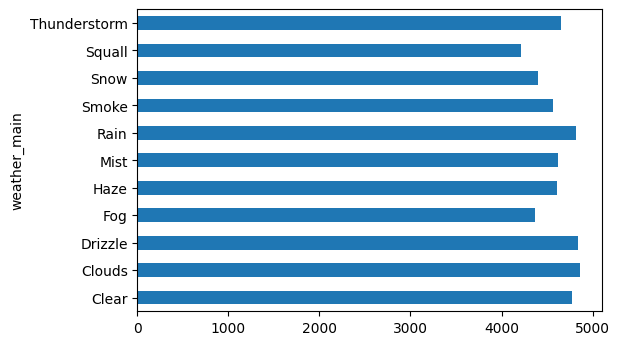

In [21]:
by_weather_main['traffic_volume'].plot.barh()
plt.show()

It does not appear that there is any traffic volume exceeding 5,000 cars. There are not any weather types that stick out as particularly heavy indicators.

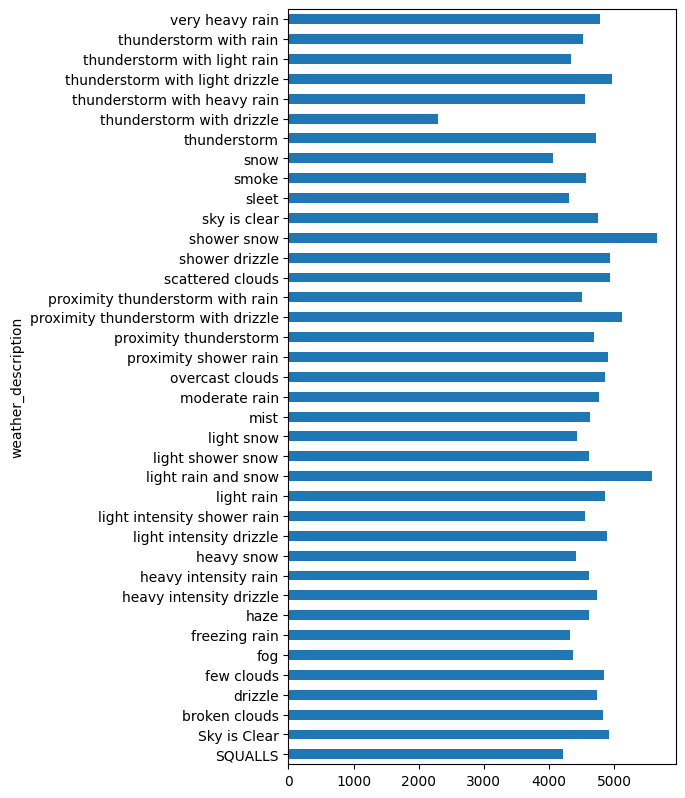

In [22]:
by_weather_description['traffic_volume'].plot.barh(figsize=(5,10))
plt.show()

Here, there are a couple indicators that exceed 5,000 cars:

* light rain and snow
* shower snow
* proximity thunderstorm with drizzle

## Conclusions

In this project, our goal was to determine a few indicators of heavy traffic on I-94. These indicators could be weather type, time of the day, time of the week, etc.

We found two types of indicators:

* Time Indicators
    * Summer months, in general, have heavier traffic than winter months.
    * Business days are significantly heavier for traffic than weekends.
    * On business days, the heaviest times are at 7 A.M. and 4 P.M.
* Weather Indicators
    * light rain and snow
    * shower snow
    * promximity thunderstorm with drizzle